In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

(37.480245721159214, 17.138320305523514, 51.25939791826632)
104.01425743373937


<IPython.core.display.Javascript object>


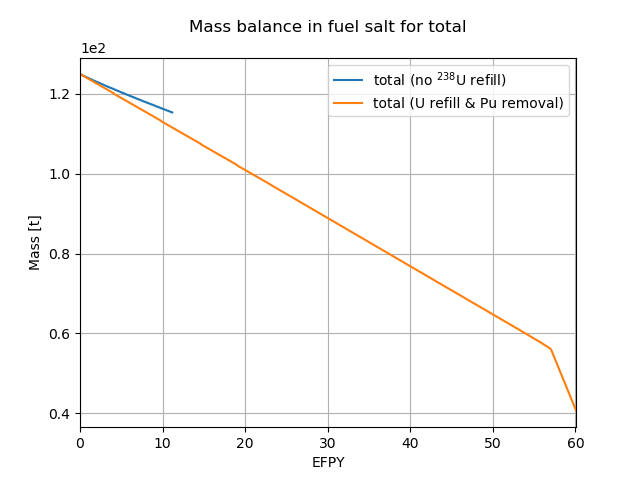

<IPython.core.display.Javascript object>


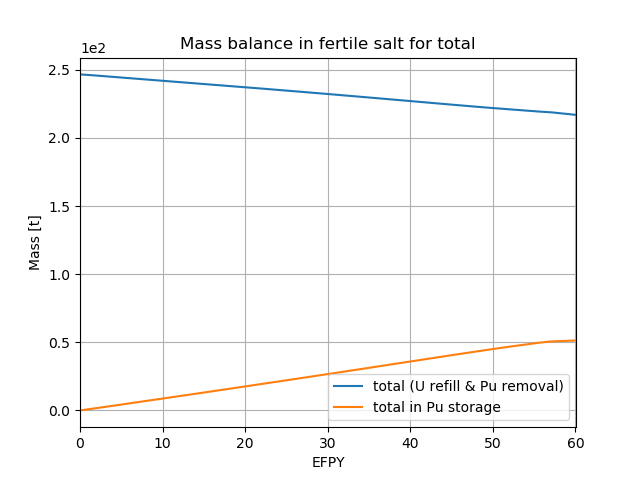

<IPython.core.display.Javascript object>


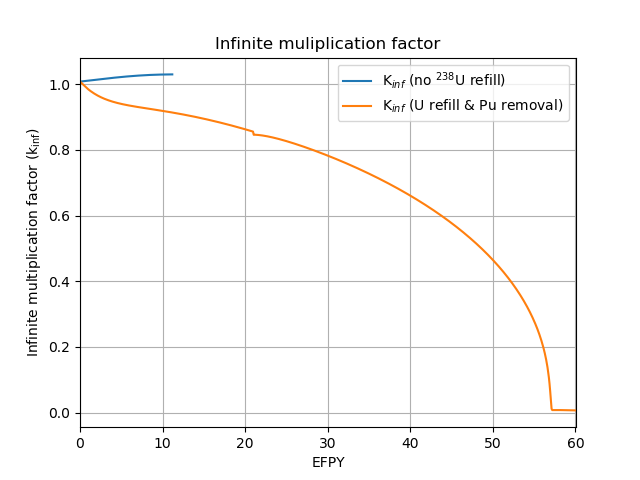

Breeding gain 702.8167794335889 kg/year
Breeding gain coefficient 0.090969875
Doubling time (net) 10.99264998439774 yrs
total inventory in driver at the beginning and end of cycle [124.90495878308678, 40.671932714515975] t
total inventory in blanket at the beginning and end of cycle [246.60931590115007, 216.88115960732853] t

Normalization coefficient for driver (fuel) 97.2780023204
Normalization coefficient for blanket (fertile) 441.240501861

Total power generated over lifetime 160.05895806884766 GWe-y
Fed material: U238 in driver 44.462633, U238 in blanket 33.890458
Natural Uranium required per energy generated 1.0489824259382663 t/GWe-y, Bin ID: A

Fission Products reprocessed continuously over lifetime 143.09593714588706 t
SNF+HLW overlifetime 294.7710655227825 t
Mass of SNF+HLW disposed per energy generated 0.6405791105084401 t/GWe-y, Bin ID: A
Cs, Ba,  Rb, Sr reprocessing group 0.029124 t; rate of removal 2.2674546537e-07 g/(s*MTU)
Adjusting U238 feed rate into driver 5.66739869

In [37]:
%matplotlib notebook 
# Import modules
import numpy as np
import matplotlib.pyplot
from pyne import serpent
from pyne import nucname
from scipy.stats.stats import pearsonr 
from scipy.stats import linregress
import itertools
##### Normalization coefficient for driver (fuel)     97.29472420072297 MTIHM
##### Normalization coefficient for blanket (fertile) 441.2158071612657 MTIHM
###################################################################################################
#vol_fuel_se    = [38.0E+6]
#vol_blank_se   = [75.0E+6]
##### Input parameters ####################
power = 6.0*0.444                             # GW electric, thermal efficiency 44.4% assumed (MSBR)
vol_driver= 38.0E+6
vol_blank = 75.0E+6
MTHM_fuel = 67.78803
MTHM_blank= 133.76272
u238_feed_f = 3.4617029105E-04                # g/(s*MTIHM) from SCALE input
u238_feed_b = 1.337180327E-04                 # g/(s*MTIHM) from SCALE input
normaliz_coeff = MTHM_fuel/6.968485e-1        # MTIHM for T=0 / Normalized HM mass (t) from *.out [97.29472420072297]
vol_fuel_se      = normaliz_coeff
vol_blank_se     = normaliz_coeff             #[133.75523/3.031515e-1]#[441.2158071612657]
vol_pu_storage   = normaliz_coeff             #[133.75523/3.031515e-1]
vol_unirradiated = MTHM_blank/3.031515e-1-normaliz_coeff
vol_waste        = normaliz_coeff             #vol_driver * (51.263294/390632.937500)     # in brackets volume ratio from SCALE output (mix4/mix1)
iso = 'total'
waste_iso = 'xe134'
# SCALE output
# No reprocessing case
filename_fuel0  = '/home/andrei2/Desktop/ornl/mcsfr/scale/no_reproc_depl/4080efd/mcsfr_no_move_4080d.000000000000000000.plt'
filename_blank0 = '/home/andrei2/Desktop/ornl/mcsfr/scale/no_reproc_depl/4080efd/mcsfr_no_move_4080d.000000000000000001.plt'
k_file0 = '/home/andrei2/Desktop/ornl/mcsfr/scale/no_reproc_depl/4080efd/mcsfr_no_move_4080d.out'
# No feed case, no Pu removal from blanket
filename_fuel4  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/onlyRemovals/4080d/mcsfr/mcsfr_opus_after.000000000000000000.plt'
filename_blank4 = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/onlyRemovals/4080d/mcsfr/mcsfr_opus_after.000000000000000001.plt'
k_file4 = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/onlyRemovals/4080d/mcsfr/mcsfr_all_removals_no_feeds.out'
# U238 feed in both, Pu removal from blanket
filename_fuel_feed  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr6/mcsfr_all_removal_u_feed_60yrs.000000000000000000.plt'
filename_blank_feed = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr6/mcsfr_all_removal_u_feed_60yrs.000000000000000001.plt'
filename_waste  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr6/mcsfr_all_removal_u_feed_60yrs.000000000000000002.plt'
filename_pu     = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr6/mcsfr_all_removal_u_feed_60yrs.000000000000000003.plt'
k_file_feed = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr6/mcsfr_all_removal_u_feed_60yrs.out'
#filename_fuel_feed  = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_opus_after.000000000000000000.plt'
#filename_blank_feed = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_opus_after.000000000000000001.plt'
#filename_waste      = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr5/mcsfr_opus_after.000000000000000000.plt'
#filename_pu     = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_opus_after.000000000000000002.plt'
#k_file_feed = '/home/andrei2/Dropbox/study/internships/ornl/science/forAndrei/mcsfr2/mcsfr_all_removal_u_feed_4080d.out'

def read_scale_out (filename):
    iso       = []
    adens     = []
    days_list = []
    with open(filename,'r') as infile:
        for line in itertools.islice(infile, 5, None):  # Skip file header start=6, stop=None
            p = line.split()
            iso.append(str(p[0]))
            adens.append(p[1:])  
            #iso.append(str(p[2]))
            #adens.append(str(p[3]))
    #u_en = 1e-6* np.flip (np.array (upp_enrg, dtype=float), 0 )               # Convert eV to MeV
    #flux = np.flip ( np.array (flux_list, dtype=float), 0 )
    #num_gr = len (u_en)
    days_list.append (iso[0])
    days_list = days_list + adens[0][:]
    adens_arr = np.asarray(adens[1:][:], dtype=np.float32)
    days = np.array (days_list, dtype=np.float32)
    return iso[1:], days/365, adens_arr/1e+6

def read_scale_k (filename):
    kinf = []
    with open(filename) as openfile:
        for line in openfile:
            if line.startswith('      Infinite neutron multiplication'):
                num = line.split(' ')[-1].strip()
                kinf.append(float(num))
    return kinf[1:]

def heavy_metal_mass (iso_name, days, mdens, vol):
    iso = []
    mthm = 0.0
    for k in range (len(iso_name)-2):
        if nucname.znum(iso_name[k]) > 89:
            iso.append(iso_name[k])
            mthm += mdens[k] * vol
    return mthm

def mass_of_elements (n_sc, mdens, vol, list_of_elements):
    mass = []
    for k in list_of_elements:
        for g in range(len(n_sc)-2):
            if nucname.znum(k) == nucname.znum(n_sc[g]):
                mass.append(mdens[g,-1]*vol )
    return sum (mass)                          # total mass, t

kinf0     = read_scale_k (k_file0)
kinf4     = read_scale_k (k_file4)
kinf_feed = read_scale_k (k_file_feed)

# No reproc case
n_sc0, days_sc, mdens_fuel_sc0          = read_scale_out (filename_fuel0)
n_sc_blanket0, days_sc, mdens_blank_sc0 = read_scale_out (filename_blank0)

# No feed case
n_sc4, days_sc, mdens_fuel_sc4          = read_scale_out (filename_fuel4)
n_sc_blanket4, days_sc, mdens_blank_sc4 = read_scale_out (filename_blank4)

# Feed and Pu removal case
n_f_feed, days_sc_f, mdens_f_feed       = read_scale_out (filename_fuel_feed)
n_b_feed, days_sc_f, mdens_b_feed       = read_scale_out (filename_blank_feed)
n_sc_waste, days_sc_f, mdens_waste      = read_scale_out (filename_waste)
n_sc_pu, days_sc_pu, mdens_pu           = read_scale_out (filename_pu)

# Heavy metal inventory
u238_0  =  (mdens_f_feed[n_f_feed.index('u238'),0]+mdens_b_feed[n_b_feed.index('u238'),0])*vol_fuel_se
u235_0  =  (mdens_f_feed[n_f_feed.index('u235'),0]+mdens_b_feed[n_b_feed.index('u235'),0])*vol_fuel_se
pu239_0 =  (mdens_f_feed[n_f_feed.index('pu239'),0]+mdens_b_feed[n_b_feed.index('pu239'),0])*vol_fuel_se

u238_e  =  (mdens_f_feed[n_f_feed.index('u238'),-1]+mdens_b_feed[n_b_feed.index('u238'),-1])*vol_fuel_se
u235_e  =  (mdens_f_feed[n_f_feed.index('u235'),-1]+mdens_b_feed[n_b_feed.index('u235'),-1])*vol_fuel_se
pu239_e =  (mdens_f_feed[n_f_feed.index('pu239'),-1]+mdens_b_feed[n_b_feed.index('pu239'),-1])*vol_fuel_se

#MTHM_fuel                               = heavy_metal_mass (n_sc4, days_sc, mdens_fuel_sc4,vol_fuel_se)
#MTHM_blanket                            = heavy_metal_mass (n_sc_blanket4, days_sc, mdens_blank_sc4,vol_blank_se)
#MTHM_pu                                 = heavy_metal_mass (n_sc_pu, days_sc, mdens_pu,vol_blank_se)

tot_m_no  = mdens_fuel_sc4[n_sc4.index('pu239'),]*vol_fuel_se+mdens_blank_sc4[n_sc_blanket4.index('pu239'),]*vol_blank_se
tot_m_feed= mdens_f_feed[n_f_feed.index('pu239'),]*vol_fuel_se+mdens_b_feed[n_b_feed.index('pu239'),]*vol_blank_se+mdens_pu[n_sc_pu.index('pu239'),]*vol_pu_storage

# Online reprocessed materials
# U238 fed over lifetime
u238_f_consumed = u238_feed_f * MTHM_fuel * days_sc_f[-1] * 24 * 365 * 3600 * 1e-6   # t uranium fed into the core
u238_b_consumed = u238_feed_b *MTHM_blank * days_sc_f[-1] * 24 * 365 * 3600 * 1e-6   # t uranium fed into the blanket
u_balance     =  u235_0+u238_0+u238_f_consumed+u238_b_consumed-u235_e-u238_e                # initial U + fed U - U left after 60yrs
# FP removed continuously over lifetime
fp_removed    = mdens_waste[n_sc_waste.index('total')][-1]*vol_waste
##### Recovered materials from the fuel salt
recovered_mat_list = ['na','cl','u','pu']                  # list of useful materials we wanna recover after reactor shutdown
mass_recovered_mat = mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, recovered_mat_list)+mass_of_elements(n_b_feed, mdens_b_feed, vol_fuel_se, recovered_mat_list)+mass_of_elements(n_sc_pu, mdens_pu, vol_pu_storage, recovered_mat_list)
print (mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, recovered_mat_list), 
       mass_of_elements(n_b_feed, mdens_b_feed, vol_fuel_se, recovered_mat_list),
       mass_of_elements(n_sc_pu, mdens_pu, vol_waste, recovered_mat_list))

print (mdens_b_feed[n_b_feed.index('u238'),0]*vol_unirradiated)
##################### Fuel cycle metrics Generated (2.1.14) ###############
nat_u_per_energy = u_balance / (power*days_sc_f[-1])                        # Natural Uranium per energy generated
snf_hlw_per_energy= (fp_removed+(mdens_f_feed[n_f_feed.index('total'),-1]+mdens_b_feed[n_b_feed.index('total'),-1])
                     *vol_fuel_se-mass_recovered_mat)/(power*days_sc_f[-1])  # SNF+HLW per energy generated
if nat_u_per_energy>=0 and nat_u_per_energy<3.8:
    metric_resource_utilization = 'A'
elif nat_u_per_energy>=3.8 and nat_u_per_energy<35.0:
    metric_resource_utilization = 'B'
elif nat_u_per_energy>=35.0 and nat_u_per_energy<145.0:
    metric_resource_utilization = 'C'
else: 
    metric_resource_utilization = 'D'

if snf_hlw_per_energy>=0 and snf_hlw_per_energy<1.65:
    metric_mass_of_snf_hlw = 'A'
elif snf_hlw_per_energy>=1.65 and snf_hlw_per_energy<3.0:
    metric_mass_of_snf_hlw = 'B'
elif snf_hlw_per_energy>=3.0 and snf_hlw_per_energy<6.0:
    metric_mass_of_snf_hlw = 'C'
elif snf_hlw_per_energy>=6.0 and snf_hlw_per_energy<=12.0:
    metric_mass_of_snf_hlw = 'D'
elif snf_hlw_per_energy>=12 and snf_hlw_per_energy<=36:
    metric_mass_of_snf_hlw = 'E'
else: 
    metric_mass_of_snf_hlw = 'F'

############################### GRAPHIC HERE ##############################################################
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#ax.set_ylim(0,0.00555)
#for i in [n_se.index(iso.capitalize())]:
    #ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+' (no removals)')
    #ax.plot(days, mdens_fuel_se[i,:]*vol_fuel_se[0]+mdens_blank_se[i,:]*vol_blank_se[0], '--',color='#ff8100',
    #        label=nucname.serpent(n_se[i])+'(w/ blanket, no removals)')
    #ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+'(Serpent, blanket)')
#for i in [n_se1.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se1[i,:]*vol_fuel_se[0], '-',color='red',
#            label=nucname.serpent(n_se1[i])+' Serpent(gases removal)')
#for i in [n_se2.index(iso.capitalize())]:
#    ax.plot(days, mdens_fuel_se2[i,:]*vol_fuel_se[0], '--',color='green', 
#            label=nucname.serpent(n_se2[i])+' Serpent(volatile gases, noble metals, \nrare earths&discard)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc[n_sc.index(k)]*vol_fuel_se[0], '-',color='#ff8100', label=k+'(no removals)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc1[n_sc1.index(k)]*vol_fuel_se[0], '+--',color='blue', label=k+'(gases)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc2[n_sc2.index(iso)]*vol_fuel_se[0], '-',color='black', label=k+'(gases&noble)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc0[n_sc0.index(k)]*vol_fuel_se[0], '--', label=k+' (no reprocessing)')
for k in [iso]:
    ax.plot(days_sc, mdens_fuel_sc4[n_sc4.index(k)]*vol_fuel_se, '-', label=k+' (no $^{238}$U refill)')
for k in [iso]:
    ax.plot(days_sc_pu, mdens_f_feed[n_f_feed.index(k)]*vol_fuel_se, '-', label=k+' (U refill & Pu removal)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_fuel_sc4[n_sc4.index(k)]*vol_fuel_se+mdens_blank_sc4[n_sc_blanket4.index(k)]*vol_blank_se, 
#            '-', label='Total')
ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPY')
ax.set_title('Mass balance in fuel salt for ' + str (iso)+'\n')
ax.set_xlim([0,np.amax(days_sc_pu)])
#ax.set_xlim ([0,320*3])
#ax.set_ylim([0, np.amax(tot_mass_sc)])
fig_1.show()
#fig_1.savefig(str(iso)+'_core_60yrs.png',bbox_inches='tight', dpi=900)

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
ax.ticklabel_format (style='sci',scilimits=(0,0),axis='y')
#for i in [n_se.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se[i,:]*vol_blank_se[0], '-',color='#ff8100', label=nucname.serpent(n_se[i])+' (no removals)')
#for i in [n_se1.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se1[i,:]*vol_blank_se[0], '-',color='red', label=nucname.serpent(n_se1[i])+' Serpent(gases removal)')
#for i in [n_se2.index(iso.capitalize())]:
#    ax.plot(days, mdens_blank_se2[i,:]*vol_blank_se[0], '--',color='blue', label=nucname.serpent(n_se2[i])+' Serpent(volatile gases, noble metals, \nrare earths&discard)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc[n_sc_blanket.index(k)]*vol_blank_se[0], '-',color='#ff8100', label=k+'(no removals)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc1[n_sc_blanket1.index(k)]*vol_blank_se[0], '+--',color='blue', label=k+'(gases)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc2[n_sc_blanket2.index(k)]*vol_blank_se[0], '-',color='black', label=k+'(gases&noble)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc0[n_sc_blanket0.index(k)]*vol_blank_se[0], '+--',label=k+' (no reprocessing)')
#for k in [iso]:
#    ax.plot(days_sc, mdens_blank_sc4[n_sc_blanket4.index(k)]*vol_blank_se[0], '-', label=k+' (no $^{238}$U refill)')
for k in [iso]:
    ax.plot(days_sc_pu, mdens_b_feed[n_b_feed.index(k)]*vol_blank_se+
            mdens_b_feed[n_b_feed.index(k),0]*vol_unirradiated, '-', label=k+' (U refill & Pu removal)')
for k in [iso]:
    ax.plot(days_sc_pu, mdens_pu[n_sc_pu.index(k)]*vol_pu_storage, '-', label=k+' in Pu storage')
ax.legend(loc=0)
ax.set_ylabel('Mass [t]')
ax.set_xlabel('EFPY')
ax.set_title('Mass balance in fertile salt for ' + str (iso))
ax.set_xlim([0,np.amax(days_sc_pu)])
#ax.set_xlim ([0,3*320])
#ax.set_ylim ([0,np.amax()])
fig_2.show()
#fig_2.savefig(str(iso)+'_blanket_60yrs.png',bbox_inches='tight', dpi=700)

# Initialize figure
fig_4 = matplotlib.pyplot.figure(4)
ax = fig_4.add_subplot(111)
ax.grid(True)
#ax.plot(days_sc, kinf0, '-',color='#ff8100', label='no removals')
#ax.plot(days_sc, kinf1, '-',color='blue', label='gases')
#ax.plot(days_sc, kinf2, '-',color='black', label='gases&noble')
#ax.plot(days_sc, kinf3, '-',color='red', label='gases&noble\n&rare earths')
#ax.plot(days_sc, kinf0, '-', label='K$_{inf}$ (no reprocessing)')
ax.plot(days_sc, kinf4, '-', label='K$_{inf}$ (no $^{238}$U refill)')
ax.plot(days_sc_pu, kinf_feed, '-', label='K$_{inf}$ (U refill & Pu removal)')
ax.legend(loc=0)
ax.set_ylabel('Infinite multiplication factor (k$_{\inf}$)')
ax.set_xlabel('EFPY')
ax.set_title('Infinite muliplication factor')
ax.set_xlim([0,np.amax(days_sc_pu)])
#ax.set_xlim ([0,960])
#ax.set_ylim ([0.93, 1.04])
fig_4.show()
#fig_4.savefig('k_60yrs.png',bbox_inches='tight', dpi=700)
'''
# Initialize figure
fig_5 = matplotlib.pyplot.figure(5)
ax = fig_5.add_subplot(111)
ax.grid(True)
ax.plot(days_sc, MTHM_fuel, '-',color='green', label='MTHM in core')
ax.plot(days_sc, MTHM_blanket, '-',color='blue', label='MTHM in blanket')
#ax.plot(days_sc, MTHM_pu, '-',color='#ff8100', label='MTHM in Pu tank')
ax.legend(loc=0)
ax.set_ylabel('Metric tons')
ax.set_xlabel('EFPD')
ax.set_title('Heavy Metal Loading')
ax.set_xlim([0,np.amax(days_sc)])
fig_4.show()
#fig_4.savefig('k_inf_Th_feed.png',bbox_inches='tight', dpi=700)
'''

print ('Breeding gain ' + str (1e+3*(tot_m_feed[-1]-tot_m_feed[0])/days_sc_f[-1]) + ' kg/year' )
print ('Breeding gain coefficient ' + str ((tot_m_feed[-1] - tot_m_feed[0])/(tot_m_feed[0] * days_sc_f[-1])) )
#print ('Breeding gain in blanket ' + str (1e+3*365*(mdens_blank_sc4[n_sc_blanket4.index(iso),-1]*vol_blank_se[0] + mdens_pu[n_sc_pu.index(iso),-1]*vol_pu_storage[0])/days_sc[-1]) + ' kg/year' )
print ('Doubling time (net) ' + str( 1/((tot_m_feed[-1] - tot_m_feed[0])/(tot_m_feed[0] * days_sc_f[-1]))  ) + ' yrs')

##print (tot_mass_sc[-1] - tot_mass_sc[0])
print (str(iso)+' inventory in driver at the beginning and end of cycle '+ 
       str ([mdens_f_feed[n_f_feed.index(iso),0]*vol_fuel_se,
            mdens_f_feed[n_f_feed.index(iso),-1]*vol_fuel_se])  + ' t' )
print (str(iso)+' inventory in blanket at the beginning and end of cycle '+ 
       str ([mdens_b_feed[n_b_feed.index(iso),0]*vol_blank_se+
            mdens_b_feed[n_b_feed.index(k),0]*vol_unirradiated,
            mdens_b_feed[n_b_feed.index(iso),-1]*vol_blank_se+
            mdens_b_feed[n_b_feed.index(k),0]*vol_unirradiated])  + ' t' )
#print (mdens_fuel_sc4[n_sc_blanket4.index(iso),0]*vol_fuel_se)

print('\nNormalization coefficient for driver (fuel) ' + str (MTHM_fuel/6.968485e-1)    )
print('Normalization coefficient for blanket (fertile) ' + str (MTHM_blank/3.031515e-1)    )

print ('\nTotal power generated over lifetime ' + str (power*days_sc_f[-1]) + ' GWe-y')
print ('Fed material: U238 in driver %f, U238 in blanket %f' %(u238_f_consumed, u238_b_consumed))
print ('Natural Uranium required per energy generated ' + str ( nat_u_per_energy ) 
       + ' t/GWe-y, Bin ID: ' + str (metric_resource_utilization) )

print ('\nFission Products reprocessed continuously over lifetime ' + str ( fp_removed) + ' t')
print ('SNF+HLW overlifetime ' + str (fp_removed+(mdens_f_feed[n_f_feed.index('total'),-1]+
        mdens_b_feed[n_b_feed.index('total'),-1])*vol_fuel_se + 
        mdens_b_feed[n_b_feed.index('total'),0]*vol_unirradiated - mass_recovered_mat ) + ' t' )
print ('Mass of SNF+HLW disposed per energy generated ' +
       str (snf_hlw_per_energy) +' t/GWe-y, Bin ID: '+str (metric_mass_of_snf_hlw))
#print ('Mass of DU+RU+RTh disposed per energy generated: ' + str(0) + ' Bin ID: A' )

#print ('\nProducts from Rep/Sep technology RU: %f, TRU: %f, FP: %f.' 
#       %(mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['u']),
#         mass_of_elements(n_sc, mdens_fuel_sc, vol_fuel_se, ['pu','np','am','cm']),
#         fp_removed))

print ('Cs, Ba,  Rb, Sr reprocessing group %f t; rate of removal %.10e g/(s*MTU)'
       %(mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['cs','ba','rb','sr']),
         1e+6*mass_of_elements(n_f_feed, mdens_f_feed, vol_fuel_se, ['cs','ba','rb','sr'])/(365*24*3600*MTHM_fuel*days_sc_f[-1])))

print ( "Adjusting U238 feed rate into driver %.10e g/(s*MTU)"
      %(u238_feed_f+1e6*np.diff([mdens_f_feed[n_f_feed.index('total'),-1]*vol_fuel_se,
            mdens_f_feed[n_f_feed.index('total'),0]*vol_fuel_se])/(3600*24*365*(MTHM_blank+MTHM_fuel)*days_sc_f[-1])  ) ) 
print ( "Adjusting U238 feed rate into blanket %.10e g/(s*MTU)"
       %(u238_feed_b+1e6*np.diff([mdens_b_feed[n_b_feed.index('u238'),-1]*vol_blank_se+
            mdens_b_feed[n_b_feed.index('u238'),0]*vol_unirradiated,
            mdens_b_feed[n_b_feed.index('u238'),0]*vol_blank_se+
            mdens_b_feed[n_b_feed.index('u238'),0]*vol_unirradiated]) / (3600*24*365*(MTHM_blank+MTHM_fuel)*days_sc_f[-1])  )  )

balance_fuel = (mdens_f_feed[:-2,-1] - mdens_f_feed[:-2,0])*vol_fuel_se
for i in range (len(balance_fuel)):
    if balance_fuel[i] >= 0.1:
        print (balance_fuel[i], n_f_feed[i])
balance_blanket = (mdens_b_feed[:-2,-1] - mdens_b_feed[:-2,0])*vol_fuel_se
print ('Blanket')
for i in range (len(balance_blanket)):
    if balance_blanket[i] >= 0.02:
        print (balance_blanket[i]*1000, n_b_feed[i])